# 00X.00X Modeling - Treeviz

In [1]:
import pathlib
import sys
import joblib

import pandas as pd
import numpy as np
import missingno as msno

# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats import poisson, nbinom
from dtreeviz.trees import *


import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload all modules
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import get_model_diagnosis
from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked
from src.data.stacked_to_ts_featured import clean_df
from src.models.metrics import insert_rps
from src.betting.simulate import simulate_betting

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

# fn = '2007-2008__2017-2018.csv'
# EDA_FP = SAMPLE_DIR / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
# SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

fn = '2007-2008__2017-2018.csv'
SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / fn
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / fn
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / fn
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'
SAMP_CAL_FP = SAMPLE_DIR / 'models' / 'calibration-model.joblib'
SAVE_FP = SAMPLE_DIR / 'check-output' / 'test.csv'

In [2]:
SAMP_FEATURED_SUBDIRS  = str(SAMP_FEATURED_DIR) + '/*/'
SAMP_TRANSFORMED_SUBDIRS = str(SAMP_TRANSFORMED_DIR) + '/*/' 

In [3]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   ├── 2007-2008__2017-2018.csv
│   ├── germany
│   │   └── bundesliga
│   │       └── 2007-2008__2017-2018.csv
│   └── italy
│       └── serie-a
│           └── 2010-2011__2017-2018.csv
├── check-output
│   └── test.csv
└── models
    ├── calibration-model.joblib
    ├── good-calibration-model.joblib
    └── optimized-model.joblib

16 directories, 11 files


## 1. Select Features

In [4]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [5]:
df_temp = df_trans.copy(deep=True)

from src.features.manipulation import (cut_historical_games,
                                       select_features,
                                       get_feature_name_stubs_from_base,
                                       get_base_features,
                                       get_df_from_base_features,
                                       get_features_df,
                                       get_non_features_df,
                                       get_target_df)

In [6]:
base_features = get_base_features(df_temp)
base_features

['corners',
 'fouls',
 'ftGoals',
 'htGoals',
 'impliedDraw',
 'impliedLose',
 'impliedWin',
 'poissDraw',
 'poissLose',
 'poissWin',
 'redCards',
 'shots',
 'shotsOnTarget',
 'yellowCards']

In [7]:
selected_base_features = base_features
df_select_features = get_df_from_base_features(df_trans, selected_base_features)
df_select_features.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_corners-0,h_h_corners-0,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_corners-6,a_h_corners-6,h_a_corners-6,h_h_corners-6,a_a_corners-7,a_h_corners-7,h_a_corners-7,h_h_corners-7,a_a_corners-8,a_h_corners-8,h_a_corners-8,h_h_corners-8,a_a_corners-9,a_h_corners-9,h_a_corners-9,h_h_corners-9,a_a_corners-10,a_h_corners-10,h_a_corners-10,h_h_corners-10,a_a_corners-11,a_h_corners-11,h_a_corners-11,h_h_corners-11,a_a_corners-12,a_h_corners-12,h_a_corners-12,h_h_corners-12,a_a_corners-13,a_h_corners-13,h_a_corners-13,h_h_corners-13,a_a_corners-14,a_h_corners-14,h_a_corners-14,h_h_corners-14,a_a_corners-15,a_h_corners-15,h_a_corners-15,h_h_corners-15,a_a_corners-16,a_h_corners-16,h_a_corners-16,h_h_corners-16,a_h_corners-17,h_a_corners-17,a_a_fouls-0,h_h_fouls-0,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_fouls-6,a_h_fouls-6,h_a_fouls-6,h_h_fouls-6,a_a_fouls-7,a_h_fouls-7,h_a_fouls-7,h_h_fouls-7,a_a_fouls-8,a_h_fouls-8,h_a_fouls-8,h_h_fouls-8,a_a_fouls-9,a_h_fouls-9,h_a_fouls-9,h_h_fouls-9,a_a_fouls-10,a_h_fouls-10,h_a_fouls-10,h_h_fouls-10,a_a_fouls-11,a_h_fouls-11,h_a_fouls-11,h_h_fouls-11,a_a_fouls-12,a_h_fouls-12,h_a_fouls-12,h_h_fouls-12,a_a_fouls-13,a_h_fouls-13,h_a_fouls-13,h_h_fouls-13,a_a_fouls-14,a_h_fouls-14,h_a_fouls-14,h_h_fouls-14,a_a_fouls-15,a_h_fouls-15,h_a_fouls-15,h_h_fouls-15,a_a_fouls-16,a_h_fouls-16,h_a_fouls-16,h_h_fouls-16,a_h_fouls-17,h_a_fouls-17,a_a_ftGoals-0,h_h_ftGoals-0,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-6,h_a_ftGoals-6,h_h_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-7,h_a_ftGoals-7,h_h_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-8,h_a_ftGoals-8,h_h_ftGoals-8,a_a_ftGoals-9,a_h_ftGoals-9,h_a_ftGoals-9,h_h_ftGoals-9,a_a_ftGoals-10,a_h_ftGoals-10,h_a_ftGoals-10,h_h_ftGoals-10,a_a_ftGoals-11,a_h_ftGoals-11,h_a_ftGoals-11,h_h_ftGoals-11,a_a_ftGoals-12,a_h_ftGoals-12,h_a_ftGoals-12,h_h_ftGoals-12,a_a_ftGoals-13,a_h_ftGoals-13,h_a_ftGoals-13,h_h_ftGoals-13,a_a_ftGoals-14,...,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_shots-4,a_h_shotsOnTarget-4,h_a_shots-4,h_a_shotsOnTarget-4,h_h_shots-4,h_h_shotsOnTarget-4,a_a_shots-5,a_a_shotsOnTarget-5,a_h_shots-5,a_h_shotsOnTarget-5,h_a_shots-5,h_a_shotsOnTarget-5,h_h_shots-5,h_h_shotsOnTarget-5,a_a_shots-6,a_a_shotsOnTarget-6,a_h_shots-6,a_h_shotsOnTarget-6,h_a_shots-6,h_a_shotsOnTarget-6,h_h_shots-6,h_h_shotsOnTarget-6,a_a_shots-7,a_a_shotsOnTarget-7,a_h_shots-7,a_h_shotsOnTarget-7,h_a_shots-7,h_a_shotsOnTarget-7,h_h_shots-7,h_h_shotsOnTarget-7,a_a_shots-8,a_a_shotsOnTarget-8,a_h_shots-8,a_h_shotsOnTarget-8,h_a_shots-8,h_a_shotsOnTarget-8,h

## 2. Select Number of Past Games to Get

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [8]:
n_back=5
df_cut = cut_historical_games(df_select_features, n_back=n_back, drop_all_nan_rows=True, how='any')
df_cut.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedDraw-5,a_h_impliedDraw-5,h_a_impliedDraw-5,h_h_impliedDraw-5,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedLose-5,a_h_impliedLose-5,h_a_impliedLose-5,h_h_impliedLose-5,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_impliedWin-5,a_h_impliedWin-5,h_a_impliedWin-5,h_h_impliedWin-5,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissDraw-5,a_h_poissDraw-5,h_a_poissDraw-5,h_h_poissDraw-5,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissLose-5,a_h_poissLose-5,h_a_poissLose-5,h_h_poissLose-5,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_poissWin-5,a_h_poissWin-5,h_a_poissWin-5,h_h_poissWin-5,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_htGoals-5,a_h_htGoals-5,h_a_htGoals-5,h_h_htGoals-5,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1

In [9]:
df_cut.shape

(2016, 351)

## 3. Prepare data For Modeling

### Prepare for Data Splitting

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [10]:
df_model = df_cut.copy(deep=True)
# Reset index prior to any splitting
df_model = df_model.sort_values(by=['date'])
df_model = df_model.reset_index(drop=True)
meta = get_non_features_df(df_model)
meta.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
0,germany,bundesliga,2007-2008,hannover,schalke,2007-11-24,2.0,3.0,awin,6.0,18.0,1.0,0.284534,0.354326,0.36114,0.302742,0.360347,0.336911,0.0,17.0,8.0,2.0,2.6,2.50,2.7,2.55,0.275,0.275,0.45,3.3,3.2,3.35,3.19,3.0,15.0,1.0,0.284534,0.36114,0.354326,0.302742,0.336911,0.360347,0.0,12.0,4.0,2.0,2.65,2.60,2.95,2.62,0.36114,0.284534,0.354326,3,0,0,1,0.405229,1.0
1,germany,bundesliga,2007-2008,hansa-rostock,hannover,2007-11-30,0.0,3.0,awin,7.0,20.0,0.0,0.284091,0.340909,0.37500,0.284063,0.364844,0.351093,0.0,19.0,10.0,1.0,2.5,2.45,2.6,2.49,0.275,0.275,0.45,3.3,3.2,3.30,3.20,6.0,12.0,0.0,0.284091,0.37500,0.340909,0.284063,0.351093,0.364844,0.0,17.0,5.0,1.0,2.75,2.65,3.05,2.68,0.37500,0.284091,0.340909,3,0,0,1,0.415033,1.0


In [11]:
meta.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
2014,germany,bundesliga,2017-2018,hoffenheim,dortmund,2018-05-12,3.0,1.0,hwin,3.0,7.0,0.0,0.250874,0.432188,0.316938,0.201886,0.499142,0.298946,0.0,10.0,4.0,0.0,3.00,3.0,3.13,2.95,0.275,0.275,0.45,3.79,3.8,4.25,3.97,2.0,4.0,1.0,0.250874,0.316938,0.432188,0.201886,0.298946,0.499142,0.0,12.0,8.0,0.0,2.20,2.20,2.4,2.18,0.316938,0.250874,0.432188,1,1,0,0,1.0,0.611111
2015,germany,bundesliga,2017-2018,wolfsburg,fc-koln,2018-05-12,4.0,1.0,hwin,10.0,17.0,1.0,0.238043,0.580592,0.181366,0.247620,0.544556,0.207823,0.0,6.0,1.0,3.0,5.25,5.0,5.50,4.98,0.275,0.275,0.45,4.00,4.1,4.36,4.11,5.0,12.0,1.0,0.238043,0.181366,0.580592,0.247620,0.207823,0.544556,0.0,16.0,8.0,2.0,1.64,1.65,1.7,1.64,0.181366,0.238043,0.580592,1,1,0,0,1.0,0.611111


In [12]:
meta.shape

(2016, 59)

In [13]:
X = get_features_df(df_model)
X.head(2)

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedDraw-5,a_h_impliedDraw-5,h_a_impliedDraw-5,h_h_impliedDraw-5,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedLose-5,a_h_impliedLose-5,h_a_impliedLose-5,h_h_impliedLose-5,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_impliedWin-5,a_h_impliedWin-5,h_a_impliedWin-5,h_h_impliedWin-5,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissDraw-5,a_h_poissDraw-5,h_a_poissDraw-5,h_h_poissDraw-5,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissLose-5,a_h_poissLose-5,h_a_poissLose-5,h_h_poissLose-5,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_poissWin-5,a_h_poissWin-5,h_a_poissWin-5,h_h_poissWin-5,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_htGoals-5,a_h_htGoals-5,h_a_htGoals-5,h_h_htGoals-5,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_redCards-5,a_h_redCards-5,h_a_redCards-5,h_h_redCards-5,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_shots-3,a_a_shotsOnTarget-3,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h

In [14]:
X.shape

(2016, 292)

In [15]:
y = get_target_df(df_model, format='single_ordinal_result_column')
y.head(2)

0    3
1    3
Name: ordinal_result, dtype: int64

In [16]:
y.shape

(2016,)

### Split Into Train Test

In [17]:
test_seasons = ['2016-2017', '2017-2018']

train_full_index = meta[~meta['season'].isin(test_seasons)].index
held_out_test_index = meta[meta['season'].isin(test_seasons)].index

meta_train_full = meta.loc[train_full_index, :]
meta_held_out_test = meta.loc[held_out_test_index, :]

X_train_full = X.loc[train_full_index, :]
X_held_out_test = X.loc[held_out_test_index, :]

y_train_full = y.loc[train_full_index]
y_held_out_test = y.loc[held_out_test_index]

In [18]:
print(meta_train_full.shape)
print(X_train_full.shape)
print(y_train_full.shape)
print()
print(meta_held_out_test.shape)
print(X_held_out_test.shape)
print(y_held_out_test.shape)

(1654, 59)
(1654, 292)
(1654,)

(362, 59)
(362, 292)
(362,)


### Split Out Calibrate

In [19]:
cal_seasons = ['2014-2015', '2015-2016']

train_val_index = meta_train_full[~meta_train_full['season'].isin(cal_seasons)].index
cal_index = meta_train_full[meta_train_full['season'].isin(cal_seasons)].index

meta_train_val = meta_train_full.loc[train_val_index, :]
meta_cal = meta_train_full.loc[cal_index, :]

X_train_val = X_train_full.loc[train_val_index, :]
X_cal = X_train_full.loc[cal_index, :]

y_train_val = y_train_full.loc[train_val_index]
y_cal = y_train_full.loc[cal_index]

In [20]:
print(meta_train_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print()
print(meta_cal.shape)
print(X_cal.shape)
print(y_cal.shape)

(1288, 59)
(1288, 292)
(1288,)

(366, 59)
(366, 292)
(366,)


In [21]:
# validate_dfs = []

# rps_adj_scores = []
# bal_acc_scores = []

def run_fit_validate(X, y, X_cal, y_cal, meta_train_val, skf, srs, clf, sig_clf):
    n = 0
    validate_dfs = []
  

    for fit_indices, validate_indices in skf.split(X, y):

        X_fit = X.iloc[fit_indices]
        y_fit = y.iloc[fit_indices]

        X_validate = X.iloc[validate_indices]
        y_validate = y.iloc[validate_indices]

        meta_fit = meta_train_val.iloc[fit_indices]
        meta_validate = meta_train_val.iloc[validate_indices]

        X_fit = srs.fit_transform(X_fit)
        clf.fit(X_fit, y_fit)

        X_validate = srs.transform(X_validate)
        validate_preds = clf.predict_proba(X_validate)

        # Probability calibration

        # sig_clf.fit(X_cal, y_cal)
        # sig_validate_preds = sig_clf.predict_proba(X_validate)

        #Build the DataFrame with the results for the validation data
        validate_preds_df = pd.DataFrame(validate_preds, columns = clf.classes_, index = meta_validate.index)

        df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
        df_validate = insert_rps(df_validate)
        df_validate = insert_rps(df_validate,
                                 prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                                 return_col_prefix='bookie')
        df_validate = insert_rps(df_validate,
                                 prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                                 return_col_prefix='baseline')


        df_validate['pred_class'] = df_validate[[1,2, 3]].idxmax(axis=1)
        df_validate['pred_result'] = df_validate['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})
        #bal_acc_scores.append(balanced_accuracy_score(df_validate['result'], df_validate['pred_result'], adjusted=True))


        df_validate['n_fold'] = n
        n += 1

        validate_dfs.append(df_validate)
    for df in validate_dfs:
        print(f"Validation Fold: {df['n_fold'].unique()[0]+1}")
        get_model_diagnosis(df, add_baseline=True)
        plt.show();
        print()
    return clf, validate_dfs

# # clf = RandomForestClassifier(class_weight='balanced', n_estimators=200,
# #                               criterion='entropy', bootstrap=False, oob_score=False)
# # clf = ExtraTreesClassifier(n_estimators=200, criterion='entropy',)
# # clf = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='brute')
# # clf = DecisionTreeClassifier()
# # clf = LGBMClassifier(objective='multiclass')
# clf = LinearDiscriminantAnalysis()
              
# n_splits=2
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
# srs = SelectiveMinMaxScaler(trans_col_name='')
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
# dfs = run_fit_validate(X_train_val, y_train_val, X_cal, y_cal, meta_train_val, skf, srs, clf, sig_clf)
# dfs[1].head()


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False): 0



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.545
Expected Calibration Error: 0.429
Maximum Calibration Error:  0.841
Number of Instances: 644


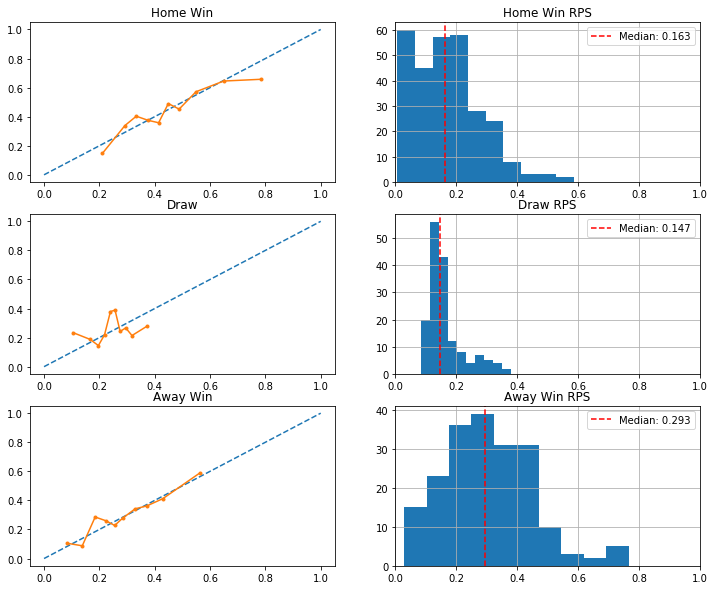


Validation Fold: 2
Average Calibration Error:  0.548
Expected Calibration Error: 0.426
Maximum Calibration Error:  0.840
Number of Instances: 644


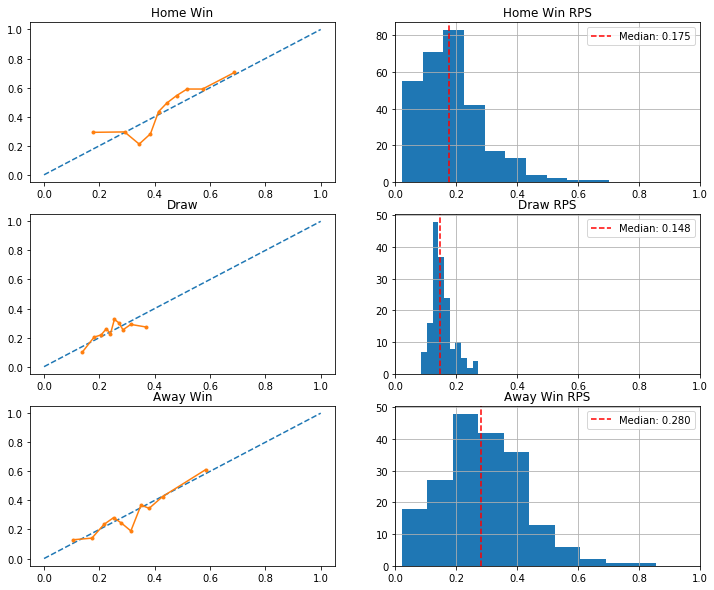


--------------------------------------------------------------------------------



In [22]:
from skoot.preprocessing import SelectiveMinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 



clfs = [RandomForestClassifier(class_weight='balanced')]
# ,
#         ExtraTreesClassifier(class_weight='balanced'),
#         LGBMClassifier(objective='multiclass'),
#         KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='brute')]


model_dict = {}
for i, clf in enumerate(clfs):
    print(f'{clf}: {i}')
    print()
    n_splits=2
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    srs = SelectiveMinMaxScaler(trans_col_name='')
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    fitted_clf, dfs = run_fit_validate(X_train_val, y_train_val,
                                       X_cal, y_cal,
                                       meta_train_val,
                                       skf, srs, clf, sig_clf)
    # Pick up the model fitted to the last fold
    model_dict[i] = fitted_clf
    print('-'*80)
    print()

### Decision Tree Viz

In [23]:
classifier = RandomForestClassifier(class_weight='balanced', max_depth=4)  # limit depth of tree
classifier.fit(X_train_val, y_train_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
#def predict_on_test(X_t, y_t, meta_t, srs, sig_clf):

viz = dtreeviz(classifier, 
               X_train_val, 
               y_train_val,
               target_name='ordinal_result',
              feature_names=X_held_out_test.columns, 
               class_names=["Home Win", "Draw", "Away Win"])
              
viz.view()

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

## XGBoost viz

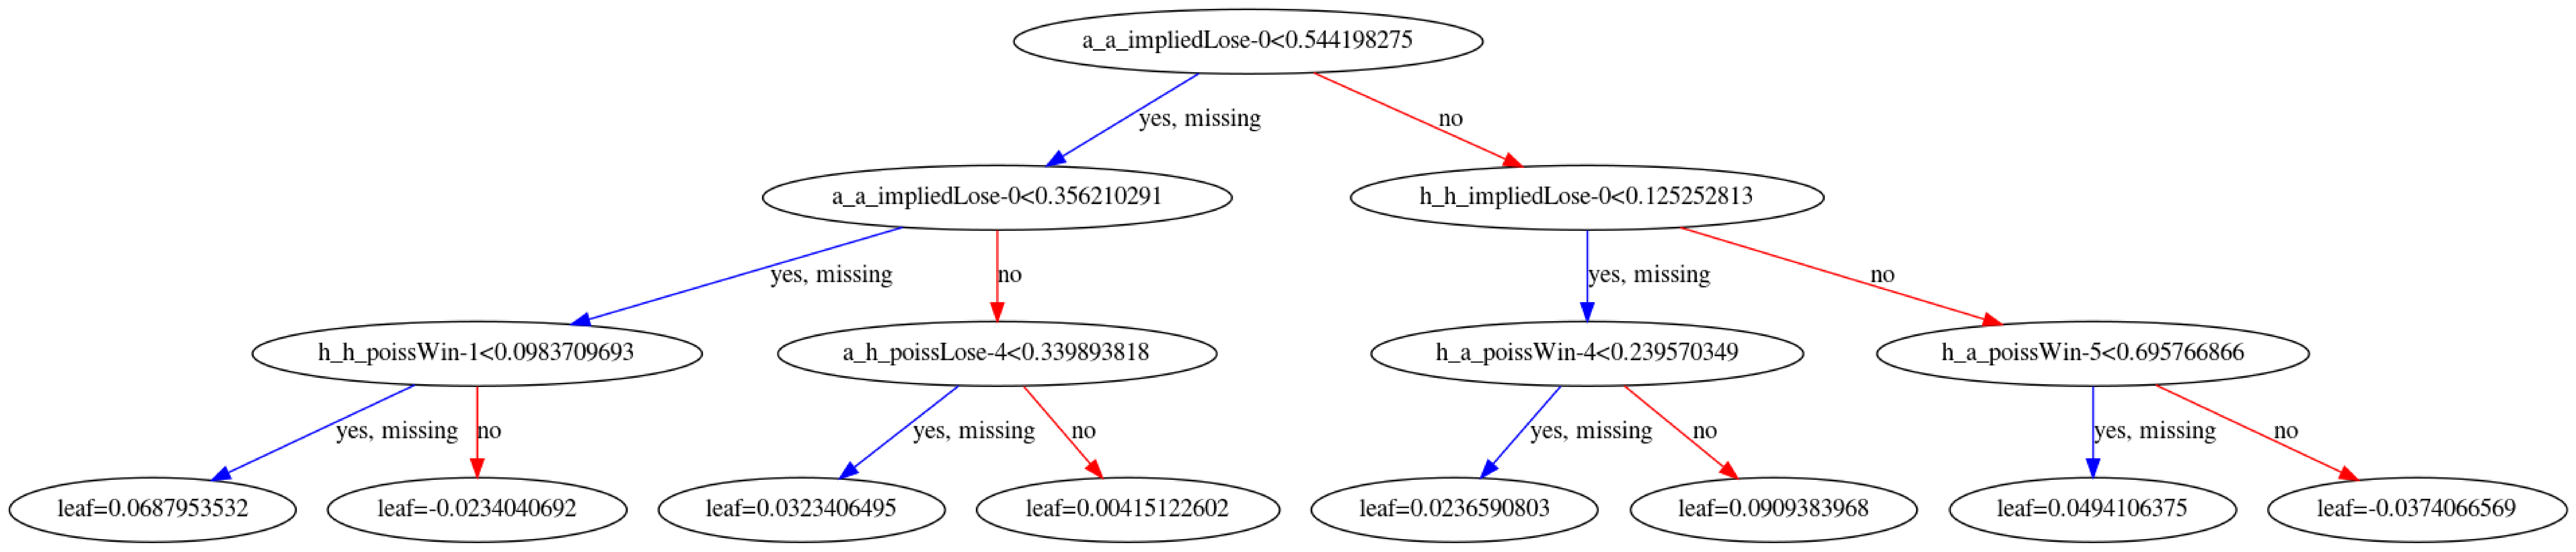

In [34]:
import matplotlib
# xgb.plot_tree(bst, num_trees=2)
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(150, 100)
# fig.savefig('tree.png')

#%matplotlib gtk
# fig, ax = plt.subplots(figsize=(14,10))
from xgboost import plot_tree
clf = XGBClassifier(objective="multi:softprob")
# model = XGBClassifier()
clf.fit(X_train_val, y_train_val)
# plot single tree
plot_tree(clf, num_trees=6)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

# plt.show()

In [ ]:
stop

In [ ]:
classifier = tree.DecisionTreeClassifier(max_depth=2)  # limit depth of tree
classifier.fit(X_train_val, y_train_val)

In [ ]:
X = X_train_val.iloc[40, :]

viz = dtreeviz(classifier, 
               X_train_val, 
               y_train_val,
               target_name='ordinal_result',
              feature_names=X_held_out_test.columns, 
               class_names=["Home Win", "Draw", "Away Win"],
              X=X)
              
viz.view()

In [ ]:
stop

In [ ]:
from IPython.display import Image, display_svg, SVG
Image(viz)

In [ ]:
# Visualize the tree
from IPython.display import display
display(viz.view())

In [ ]:
stop

In [ ]:
model_dict[2]

In [ ]:
model_dict

## Best Model?

From visual inspection, I have ExtraTreesClassifier as the top, with close competition from RandomForest, LGBM, XGBoost, Logistic Regression, and Ordinal LogisticAT

In [ ]:
clf = model_dict[2]
clf

In [ ]:
joblib.dump(clf, SAMP_MODEL_FP)

## 8. Simulate Gambling in Test Data

In [ ]:
clf = joblib.load(SAMP_MODEL_FP)
clf

## 8. Simulate Gambling in Test Data

In [ ]:
clf = joblib.load(SAMP_MODEL_FP)
clf

In [ ]:
def predict_on_test(X_t, y_t, meta_t, srs, sig_clf):
    meta_t = meta_held_out_test.copy(deep=True)
    X_t = X_held_out_test.copy(deep=True)
    y_t = y_held_out_test.copy(deep=True)

    meta_t.reset_index(drop=True, inplace=True)
    X_t.reset_index(drop=True, inplace=True)
    y_t.reset_index(drop=True, inplace=True)
    
    
    X_t = srs.transform(X_t)
    test_preds = sig_clf.predict_proba(X_t)
    test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
    df_test = pd.concat([meta_t, test_preds_df], sort=False, axis=1)

    df_test['pred_class'] = df_test[[1,2, 3]].idxmax(axis=1)
    df_test['pred_result'] = df_test['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})

    df_test = insert_rps(df_test)
    df_test = insert_rps(df_test,
                             prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                             return_col_prefix='bookie')
    df_test = insert_rps(df_test,
                             prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                             return_col_prefix='baseline')
    return df_test





In [ ]:
df = predict_on_test(X_held_out_test, y_held_out_test, meta_held_out_test, srs, clf)

get_model_diagnosis(df, add_baseline=True)
plt.show();

In [ ]:
df = simulate_betting(df)

df.to_csv(SAVE_FP, index=False)

df.head(15)

In [ ]:
import ptitprince as pt
from scipy.stats import ttest_1samp

def get_betting_diagnosis(df):
    fig, ax = plt.subplots(figsize=(10,8))
    ax = pt.RainCloud(x='placed_bet', y='model_rps', data=df, width_viol=0.8, width_box=0.3,
                  orient='h', pointplot=False)
    ax.set_xlim(0.0, 1.0)
    
    bet_rets = pd.concat([df['hwin_rets'], df['draw_rets'], df['awin_rets']], axis=0)
    bet_rets = bet_rets[bet_rets != 0].values
    res = ttest_1samp(bet_rets, 0)
    t_stat = res[0]
    p_val = res[1]/2
    
    # Swarm Plot on Probabilities her
    # sns.catplot(x="day", y="total_bill", kind="swarm", data=tips);
    
    n_bets = df[["hwin_bet" , "draw_bet", "awin_bet"]].sum().sum()
    print(f'pred hwin: {df["hwin_rets"].sum()} on {df["hwin_bet"].sum()} bets')
    print(f'pred draw: {df["draw_rets"].sum()} on {df["draw_bet"].sum()} bets')
    print(f'pred awin: {df["awin_rets"].sum()} on {df["awin_bet"].sum()} bets')
    print(f'{n_bets} bets returning {df["game_ret"].sum()} over {len(df)} games')
    print(f'Overall Return: {df["game_ret"].sum()/n_bets:.3f}')
    print()
    print(f'On Sided t Test Against against Mean = 0:\n\tt_stat:\t{t_stat:.3f}\n\tp_val:\t{p_val:.3f}')
    return fig, ax


get_betting_diagnosis(df)
plt.show();

In [ ]:
df[df['placed_bet'] != 'no_bet'].head(25)

In [ ]:
df[df['placed_bet'] != 'no_bet'].tail(25)